In [ ]:
Notes on getting data:
    -https://www.premierleague.com/match/59065 gives all information (goals, yellow/red cards, fouls)
    -https://www.football-data.org/ is good API, but need to pay for yellow cards (have emailed asking for access)
    -https://github.com/openfootball/england/tree/master/2020-21 is good, but just has goals  
    -https://elenasport.io/ Looks promising, need to sign up. Have signed up, contains yellow cards. Think shall go with this.   

In [313]:
np.sqrt(20)

4.47213595499958

In [1]:
import requests

In [2]:
api_url = "https://fantasy.premierleague.com/drf/bootstrap-static"
api_response = requests.get(api_url)

In [3]:
api_response.status_code

200

In [5]:
api_response.json()

{}

In [452]:
import pandas as pd
import numpy as np
from scipy.stats import t
from datetime import datetime
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
url = "https://raw.githubusercontent.com/footballcsv/england/master/2020s/2020-21/eng.2.csv"
url_response = requests.get(url).content
# url_response.status_code

AttributeError: 'bytes' object has no attribute 'status_code'

In [9]:
csv_file = csv.reader(url_response)

In [14]:
df = pd.read_csv(url)
df.head()

,Round,Date,Team 1,FT,Team 2
0,1,Fri Sep 11 2020,Watford FC,1-0,Middlesbrough FC
1,1,Sat Sep 12 2020,Birmingham City FC,1-0,Brentford FC
2,1,Sat Sep 12 2020,Wycombe Wanderers FC,0-1,Rotherham United FC
3,1,Sat Sep 12 2020,AFC Bournemouth,3-2,Blackburn Rovers FC
4,1,Sat Sep 12 2020,Bristol City FC,2-1,Coventry City FC


In [26]:
#Getting all information for 2020-2021 season
temp_dfs = []
for i in range (1,6):
    print(i)
    join_tuple = ('https://raw.githubusercontent.com/footballcsv/england/master/2020s/2020-21/eng.', str(i), '.csv')
    url = ''.join(join_tuple)
    temp_df = pd.read_csv(url)
    temp_dfs.append(temp_df)
    print(url)
    print(len(temp_df))
for df in temp_dfs:
    overall_df = pd.concat(temp_dfs, ignore_index=True)
print(len(overall_df))    
print(overall_df.head())    

1
https://raw.githubusercontent.com/footballcsv/england/master/2020s/2020-21/eng.1.csv
380
2
https://raw.githubusercontent.com/footballcsv/england/master/2020s/2020-21/eng.2.csv
552
3
https://raw.githubusercontent.com/footballcsv/england/master/2020s/2020-21/eng.3.csv
552
4
https://raw.githubusercontent.com/footballcsv/england/master/2020s/2020-21/eng.4.csv
552
5
https://raw.githubusercontent.com/footballcsv/england/master/2020s/2020-21/eng.5.csv
506
2542
   Round             Date              Team 1   FT                Team 2
0      1  Sat Sep 12 2020          Burnley FC  NaN  Manchester United FC
1      1  Sat Sep 12 2020  Manchester City FC  NaN        Aston Villa FC
2      1  Sat Sep 12 2020           Fulham FC  0-3            Arsenal FC
3      1  Sat Sep 12 2020   Crystal Palace FC  1-0        Southampton FC
4      1  Sat Sep 12 2020        Liverpool FC  4-3       Leeds United FC


In [29]:
overall_df.columns

Index(['Round', 'Date', 'Team 1', 'FT', 'Team 2'], dtype='object')

In [31]:
overall_df.dropna(inplace=True)

In [32]:
overall_df['Sum Goals'] = overall_df['FT']

2       0-3
3       1-0
4       4-3
5       0-2
6       0-3
       ... 
2117    1-3
2118    1-2
2119    1-1
2120    5-1
2121    1-1
Name: FT, Length: 560, dtype: object

In [49]:
# overall_df['FT'].loc[1]
overall_df.iloc[0, 3]

'0-3'

In [67]:
str(overall_df.loc[1:2, ['FT']])

'    FT\n2  0-3'

In [64]:
string = '1-1'
home_goal = string[0]
away_goal = string[2]
print(home_goal, away_goal)


1 1


In [74]:
def func(series):
    for i in series:
        print(type(i))
        print(i[0])
        

In [75]:
overall_df['FT'].apply(func)

<class 'str'>
0
<class 'str'>
-
<class 'str'>
3
<class 'str'>
1
<class 'str'>
-
<class 'str'>
0
<class 'str'>
4
<class 'str'>
-
<class 'str'>
3
<class 'str'>
0
<class 'str'>
-
<class 'str'>
2
<class 'str'>
0
<class 'str'>
-
<class 'str'>
3
<class 'str'>
0
<class 'str'>
-
<class 'str'>
1
<class 'str'>
0
<class 'str'>
-
<class 'str'>
2
<class 'str'>
1
<class 'str'>
-
<class 'str'>
3
<class 'str'>
5
<class 'str'>
-
<class 'str'>
2
<class 'str'>
4
<class 'str'>
-
<class 'str'>
3
<class 'str'>
1
<class 'str'>
-
<class 'str'>
3
<class 'str'>
2
<class 'str'>
-
<class 'str'>
1
<class 'str'>
2
<class 'str'>
-
<class 'str'>
5
<class 'str'>
0
<class 'str'>
-
<class 'str'>
3
<class 'str'>
0
<class 'str'>
-
<class 'str'>
2
<class 'str'>
4
<class 'str'>
-
<class 'str'>
2
<class 'str'>
1
<class 'str'>
-
<class 'str'>
0
<class 'str'>
1
<class 'str'>
-
<class 'str'>
3
<class 'str'>
2
<class 'str'>
-
<class 'str'>
3
<class 'str'>
1
<class 'str'>
-
<class 'str'>
2
<class 'str'>
3
<class 'str'>
-
<class '

<class 'str'>
2
<class 'str'>
-
<class 'str'>
0
<class 'str'>
1
<class 'str'>
-
<class 'str'>
0
<class 'str'>
1
<class 'str'>
-
<class 'str'>
1
<class 'str'>
1
<class 'str'>
-
<class 'str'>
2
<class 'str'>
0
<class 'str'>
-
<class 'str'>
0
<class 'str'>
1
<class 'str'>
-
<class 'str'>
0
<class 'str'>
0
<class 'str'>
-
<class 'str'>
0
<class 'str'>
3
<class 'str'>
-
<class 'str'>
0
<class 'str'>
3
<class 'str'>
-
<class 'str'>
2
<class 'str'>
0
<class 'str'>
-
<class 'str'>
3
<class 'str'>
1
<class 'str'>
-
<class 'str'>
2
<class 'str'>
0
<class 'str'>
-
<class 'str'>
1
<class 'str'>
2
<class 'str'>
-
<class 'str'>
1
<class 'str'>
0
<class 'str'>
-
<class 'str'>
1
<class 'str'>
0
<class 'str'>
-
<class 'str'>
1
<class 'str'>
0
<class 'str'>
-
<class 'str'>
3
<class 'str'>
1
<class 'str'>
-
<class 'str'>
3
<class 'str'>
3
<class 'str'>
-
<class 'str'>
1
<class 'str'>
0
<class 'str'>
-
<class 'str'>
2
<class 'str'>
0
<class 'str'>
-
<class 'str'>
0
<class 'str'>
3
<class 'str'>
-
<class '

<class 'str'>
-
<class 'str'>
1
<class 'str'>
2
<class 'str'>
-
<class 'str'>
3
<class 'str'>
2
<class 'str'>
-
<class 'str'>
1
<class 'str'>
0
<class 'str'>
-
<class 'str'>
0
<class 'str'>
1
<class 'str'>
-
<class 'str'>
2
<class 'str'>
1
<class 'str'>
-
<class 'str'>
2
<class 'str'>
0
<class 'str'>
-
<class 'str'>
1
<class 'str'>
3
<class 'str'>
-
<class 'str'>
2
<class 'str'>
3
<class 'str'>
-
<class 'str'>
1
<class 'str'>
1
<class 'str'>
-
<class 'str'>
2
<class 'str'>
0
<class 'str'>
-
<class 'str'>
1
<class 'str'>
0
<class 'str'>
-
<class 'str'>
5
<class 'str'>
1
<class 'str'>
-
<class 'str'>
0
<class 'str'>
1
<class 'str'>
-
<class 'str'>
0
<class 'str'>
0
<class 'str'>
-
<class 'str'>
1
<class 'str'>
0
<class 'str'>
-
<class 'str'>
1
<class 'str'>
0
<class 'str'>
-
<class 'str'>
2
<class 'str'>
1
<class 'str'>
-
<class 'str'>
2
<class 'str'>
1
<class 'str'>
-
<class 'str'>
3
<class 'str'>
1
<class 'str'>
-
<class 'str'>
2
<class 'str'>
1
<class 'str'>
-
<class 'str'>
1
<class '

2       None
3       None
4       None
5       None
6       None
        ... 
2117    None
2118    None
2119    None
2120    None
2121    None
Name: FT, Length: 560, dtype: object

In [76]:
x=2
x

2

In [89]:
import http.client 
import json
import pprint

In [78]:
connection = http.client.HTTPConnection('api-football.org')
headers = {'X-Auth-Token' : 'babe2171ab3742158964a2e68c1e3b9c'}
connection.request('GET', '/v2/competitions/DED', None, headers)
response = json.loads(connection.getresponse().read().decode())

print (response)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [80]:
api_url = "http://api.football-data.org/v2/competitions/BL1/standings"
url_response = requests.get(url).content
headers = {'X-Auth-Token' : 'babe2171ab3742158964a2e68c1e3b9c'}
response = requests.get(api_url, headers=headers)

In [81]:
response.status_code

200

In [82]:
response_data = requests.get(api_url, headers=headers).content

In [85]:
json.loads(response_data)

{'competition': {'area': {'id': 2088, 'name': 'Germany'},
  'code': 'BL1',
  'id': 2002,
  'lastUpdated': '2021-01-07T00:00:10Z',
  'name': 'Bundesliga',
  'plan': 'TIER_ONE'},
 'filters': {},
 'season': {'currentMatchday': 15,
  'endDate': '2021-05-15',
  'id': 599,
  'startDate': '2020-09-18',
  'winner': None},
 'standings': [{'group': None,
   'stage': 'REGULAR_SEASON',
   'table': [{'draw': 3,
     'form': 'W,W,W,D,D',
     'goalDifference': 23,
     'goalsAgainst': 21,
     'goalsFor': 44,
     'lost': 1,
     'playedGames': 14,
     'points': 33,
     'position': 1,
     'team': {'crestUrl': 'https://crests.football-data.org/5.svg',
      'id': 5,
      'name': 'FC Bayern München'},
     'won': 10},
    {'draw': 4,
     'form': 'W,D,W,W,D',
     'goalDifference': 16,
     'goalsAgainst': 9,
     'goalsFor': 25,
     'lost': 1,
     'playedGames': 14,
     'points': 31,
     'position': 2,
     'team': {'crestUrl': 'https://crests.football-data.org/721.svg',
      'id': 721,
    

In [111]:
api_url = "http://api.football-data.org/v2/competitions/PL/"
headers = {'X-Auth-Token' : 'babe2171ab3742158964a2e68c1e3b9c'}
response = requests.get(api_url, headers=headers)
if (response.status_code == 200):
    response_data = requests.get(api_url, headers=headers).content
    response_data_json = json.loads(response_data)
#     pprint.pprint(response_data_json)
#     print(type(response_data_json))
#     print(type(response_data))
    pprint.pprint(response_data_json['matches'][0]['score']['fullTime']['homeTeam'])
    pprint.pprint(response_data_json['matches'][0]['score']['fullTime']['awayTeam'])
    
else:
    print("Error!")

KeyError: 'matches'

In [104]:
#Making functions to retrieve values from each part of json variable
def getHomeTeamScore(match):
    return match['score']['fullTime']['homeTeam']
def getAwayTeamScore(match):
    return match['score']['fullTime']['awayTeam']

In [112]:
pprint.pprint(response_data_json)

{'area': {'id': 2072, 'name': 'England'},
 'code': 'PL',
 'currentSeason': {'currentMatchday': 17,
                   'endDate': '2021-05-23',
                   'id': 619,
                   'startDate': '2020-09-12',
                   'winner': None},
 'emblemUrl': None,
 'id': 2021,
 'lastUpdated': '2021-01-05T01:45:01Z',
 'name': 'Premier League',
 'plan': 'TIER_ONE',
 'seasons': [{'currentMatchday': 17,
              'endDate': '2021-05-23',
              'id': 619,
              'startDate': '2020-09-12',
              'winner': None},
             {'currentMatchday': 38,
              'endDate': '2020-07-25',
              'id': 468,
              'startDate': '2019-08-09',
              'winner': None},
             {'currentMatchday': 38,
              'endDate': '2019-05-12',
              'id': 151,
              'startDate': '2018-08-10',
              'winner': None},
             {'currentMatchday': 38,
              'endDate': '2018-05-13',
              'id': 23,
     

In [106]:
getHomeTeamScore(response_data_json['matches'][0])
getAwayTeamScore(response_data_json['matches'][0])


0

In [122]:
response_data_json['match']['homeTeam']['coach']

KeyError: 'coach'

In [248]:
#Start of making functions

def makeRequest(url, querystring = {}):
    headers = {
    'x-rapidapi-key': "be5fa28e00msh131c81260ea9960p165cd5jsn0ab5a9447d39",
    'x-rapidapi-host': "elenasport-io1.p.rapidapi.com"
    }
    
    response = requests.request("GET", url, headers=headers, params = querystring)
    response_data_json = response.json()
#     print(response_data_json)
    return response_data_json

In [ ]:
#Order of getting things
Country ID
League ID
Seasons by League ID
Fixtures by Season ID
stats by Fixture ID

In [253]:
# response_data_json = response.json()
# pprint.pprint(response_data_json)

def getCountryIDfromCountryName(country_name):
    url = "https://elenasport-io1.p.rapidapi.com/v2/countries"
    querystring = {"name":"Eng","page":"1"}
    response_data_json = makeRequest(url, querystring)
    
    for keys in response_data_json['data']:
        print(keys['name'])
        if(keys['name'] == country_name):
            country_id = keys['id']
            print(f"Country id for {country_name} is {country_id}")
            return country_id

In [254]:
country_id = getCountryIDfromCountryName('England')

England
Country id for England is 27


27

In [255]:
def getLeaguesIDfromCountryID(leagues_name, country_id):
    url =  f"https://elenasport-io1.p.rapidapi.com/v2/countries/{country_id}/leagues"
    print(f"Leagues url is {url}")
    leagues_data_json = makeRequest(url)
    
    for key in leagues_data_json['data']:
        print(key['name'])
        print(leagues_name)
        if(str(key['name']) == str(leagues_name)):
            print(f"{leagues_name} id is {key['id']}")
            return key['id']
        

In [256]:
leagues_id = getLeaguesIDfromCountryID('Premier League', 27)
leagues_id

Leagues url is https://elenasport-io1.p.rapidapi.com/v2/countries/27/leagues
FA Cup
Premier League
Premier League
Premier League
Premier League id is 234


234

In [192]:
def getLeagueIDfromLeagues(leagueName, leagues_json):
    #Takes in JSON file
    for key in leagues_json['data']:
        print(key['name'])
        print(leagueName)
        if(str(key['name']) == str(leagueName)):
            
#         if(leagueName in key):
            print(f"{leagueName} id is {key['id']}")
            return key['id']
        
    
leagueID = getLeagueIDfromLeagues('Premier League', leagues_data_json)    
    

FA Cup
Premier League
Premier League
Premier League
Premier League id is 234


In [257]:
def getSeasonIDfromLeagueID(season_name, league_id):
    url = f"https://elenasport-io1.p.rapidapi.com/v2/leagues/{leagueID}/seasons"
    print(f"Season url is {url}")
    league_data_json = makeRequest(url)
    for key in league_json['data']:
        print(key['leagueName'])
        print(season_name)
        if(str(key['leagueName']) == str(season_name)):
            print(f"{season_name} id is {key['id']}")
            return key['id']
    

In [438]:
season_id = getSeasonIDfromLeagueID("Premier League - 2019/2020", leagueID)

Season url is https://elenasport-io1.p.rapidapi.com/v2/leagues/234/seasons
Premier League - 2020/2021
Premier League - 2019/2020
Premier League - 2019/2020
Premier League - 2019/2020
Premier League - 2019/2020 id is 96


In [444]:
def getFixturesfromSeasonID(season_ID):
    print(f"Getting fixtures from season ID {season_ID}")
    url = f"https://elenasport-io1.p.rapidapi.com/v2/seasons/{season_ID}/fixtures"
    print(f"Url is {url}")
    fixtureData = []
    
    for page_no in range(1, 10): 
        print(f"Getting data from page {page_no}")
        querystring = {"page":str(page_no),"expand":"stats,events"}
        season_json = makeRequest(url, querystring)

        for fixture in season_json['data']:
#             print(f"Date: {fixture['date']}")
            fixtureData.append(getFixtureStats(fixture))

    return fixtureData

In [459]:
def getFixtureStats(fixture):
    print(f"Date: {fixture['date']}")
    print(f"Score: {fixture['homeName']} {fixture['team_home_90min_goals']} - {fixture['team_away_90min_goals']} {fixture['awayName']}")

    #Getting number of y_cards
    y_card_sum = 0
    try:
        for event in fixture['expand']['events']:
            if (event['type'] == 'y_card'):
#                 print(f"{event['type']} at {event['elapsed']} minutes")
                y_card_sum = y_card_sum + 1 
    except:
        print("No events found")
    print(f"y card sum = {y_card_sum}")  
    return [datetime.strptime(fixture['date'], '%Y-%m-%d %H:%M:%S'), fixture['homeName'], fixture['awayName'], fixture['team_home_90min_goals'], fixture['team_away_90min_goals'], y_card_sum]

In [460]:
fixtureData = getFixturesfromSeasonID(season_id)

Getting fixtures from season ID 96
Url is https://elenasport-io1.p.rapidapi.com/v2/seasons/96/fixtures
Getting data from page 1
Date: 2020-06-21 13:00:00
Score: Newcastle United 3 - 0 Sheffield United
y card sum = 3
Date: 2020-06-27 11:30:00
Score: Aston Villa 0 - 1 Wolverhampton Wanderers
y card sum = 2
Date: 2020-07-01 19:15:00
Score: West Ham United 3 - 2 Chelsea
y card sum = 3
Date: 2020-07-11 11:30:00
Score: Watford 2 - 1 Newcastle United
y card sum = 5
Date: 2020-07-11 14:00:00
Score: Liverpool 1 - 1 Burnley
y card sum = 3
Date: 2020-07-11 16:30:00
Score: Sheffield United 3 - 0 Chelsea
y card sum = 1
Date: 2020-07-11 19:00:00
Score: Brighton & Hove Albion 0 - 5 Manchester City
y card sum = 1
Date: 2020-07-12 11:00:00
Score: Wolverhampton Wanderers 3 - 0 Everton
y card sum = 2
Date: 2020-07-12 13:15:00
Score: Aston Villa 2 - 0 Crystal Palace
y card sum = 6
Date: 2020-07-12 15:30:00
Score: Tottenham Hotspur 2 - 1 Arsenal
y card sum = 8
Date: 2020-07-12 18:00:00
Score: AFC Bournemou

Date: 2020-01-18 15:00:00
Score: Brighton & Hove Albion 1 - 1 Aston Villa
y card sum = 5
Date: 2020-01-18 15:00:00
Score: Manchester City 2 - 2 Crystal Palace
y card sum = 3
Date: 2020-01-18 15:00:00
Score: Southampton 2 - 3 Wolverhampton Wanderers
y card sum = 2
Date: 2020-01-18 17:30:00
Score: Newcastle United 1 - 0 Chelsea
y card sum = 2
Date: 2020-01-19 14:00:00
Score: Burnley 2 - 1 Leicester City
y card sum = 1
Date: 2020-01-19 16:30:00
Score: Liverpool 2 - 0 Manchester United
y card sum = 4
Date: 2020-01-21 19:30:00
Score: AFC Bournemouth 3 - 1 Brighton & Hove Albion
y card sum = 2
Date: 2020-01-21 19:30:00
Score: Aston Villa 2 - 1 Watford
y card sum = 4
Date: 2020-01-21 19:30:00
Score: Everton 2 - 2 Newcastle United
y card sum = 2
Date: 2020-01-21 19:30:00
Score: Sheffield United 0 - 1 Manchester City
y card sum = 7
Date: 2020-01-21 19:30:00
Score: Crystal Palace 0 - 2 Southampton
y card sum = 3
Date: 2020-01-21 20:15:00
Score: Chelsea 2 - 2 Arsenal
y card sum = 3
Date: 2020-01-

Date: 2019-10-06 13:00:00
Score: Manchester City 0 - 2 Wolverhampton Wanderers
y card sum = 7
Date: 2019-10-06 15:30:00
Score: Newcastle United 1 - 0 Manchester United
y card sum = 6
Date: 2019-10-20 15:30:00
Score: Manchester United 1 - 1 Liverpool
y card sum = 1
Date: 2019-10-21 19:00:00
Score: Sheffield United 1 - 0 Arsenal
y card sum = 8
Date: 2019-10-25 19:00:00
Score: Southampton 0 - 9 Leicester City
y card sum = 0
Date: 2019-10-26 11:30:00
Score: Manchester City 3 - 0 Aston Villa
y card sum = 3
Date: 2019-10-26 14:00:00
Score: Brighton & Hove Albion 3 - 2 Everton
y card sum = 3
Date: 2019-10-26 14:00:00
Score: Watford 0 - 0 AFC Bournemouth
y card sum = 8
Date: 2019-10-26 14:00:00
Score: West Ham United 1 - 1 Sheffield United
y card sum = 4
Date: 2019-10-26 16:30:00
Score: Burnley 2 - 4 Chelsea
y card sum = 5
Date: 2019-10-27 14:00:00
Score: Newcastle United 1 - 1 Wolverhampton Wanderers
y card sum = 3
Date: 2019-10-27 16:30:00
Score: Arsenal 2 - 2 Crystal Palace
y card sum = 2
D

In [461]:
#Reading in fixture data to dataframe
columns = ['Date', 'Home Team', 'Away Team', 'Away Goals', 'Home Goals', 'Yellow cards']
fixture_df = pd.DataFrame(data=fixtureData, columns = columns)
fixture_df.tail()

,Date,Home Team,Away Team,Away Goals,Home Goals,Yellow cards
220,2019-11-02 15:00:00,West Ham United,Newcastle United,2,3,3
221,2019-11-02 17:30:00,Watford,Chelsea,1,2,6
222,2019-11-03 14:00:00,Crystal Palace,Leicester City,0,2,4
223,2019-11-03 16:30:00,Everton,Tottenham Hotspur,1,1,3
224,2019-11-08 20:00:00,Norwich City,Watford,0,2,4


In [462]:
type(fixture_df.Date[0])

pandas._libs.tslibs.timestamps.Timestamp

In [477]:
def split_data_by_date(df, date):
    date = datetime.strptime(date, '%Y-%m-%d')
    df1 = df[df['Date'] > date]
    df2 = df[df['Date'] < date]
    
    print(f"Fixtures after {date} =  {len(df1)}")
    print(f"Fixtures before {date} =  {len(df2)}")
    
    return df1, df2
    

In [478]:
fixture_df_AC, fixture_df_BC = split_data_by_date(fixture_df, '2020-05-01')

Fixtures after 2020-05-01 00:00:00 =  62
Fixtures before 2020-05-01 00:00:00 =  163


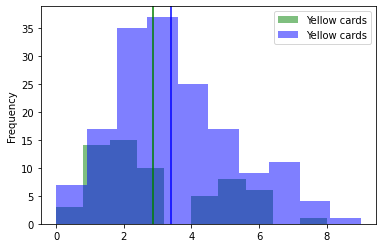

In [479]:
fixture_df_AC['Yellow cards'].plot.hist(alpha=0.5, color='green')
fixture_df_BC['Yellow cards'].plot.hist(alpha=0.5, color='blue')
plt.axvline(fixture_df_AC['Yellow cards'].mean(), color='green')
plt.axvline(fixture_df_BC['Yellow cards'].mean(), color='blue')
plt.legend()

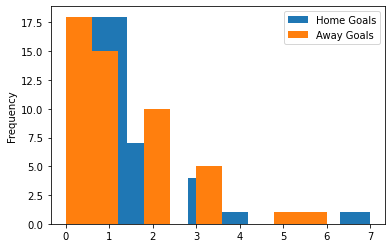

In [273]:
fixture_df['Home Goals'].plot.hist()
fixture_df['Away Goals'].plot.hist()
plt.legend()

In [272]:
len(fixture_df)

50

0     1
1     4
2     2
3     2
4     0
5     2
6     2
7     1
8     1
9     0
10    5
11    1
12    0
13    0
14    1
15    3
16    3
17    2
18    6
19    4
20    0
21    3
22    4
23    1
24    0
25    3
26    2
27    2
28    7
29    2
30    0
31    2
32    3
33    0
34    5
35    7
36    1
37    3
38    2
39    2
40    2
41    8
42    3
43    3
44    3
45    4
46    3
47    0
48    4
49    2
Name: Sum Goals, dtype: int64
2.42


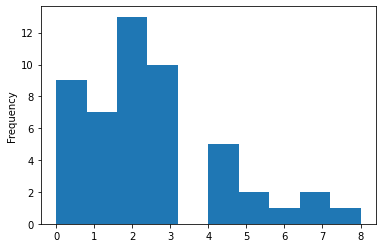

In [282]:
#Adding in sum of goals column
fixture_df['Sum Goals'] = fixture_df['Away Goals'] + fixture_df['Home Goals']
fixture_df['Sum Goals'].plot.hist()
print(fixture_df['Sum Goals'])
print(fixture_df['Sum Goals'].mean())

In [283]:
#Attempting bootstrapping goals to try to get normal distribution
fixture_df['Sum Goals'].value_counts(normalize=True)

2    0.26
3    0.20
0    0.18
1    0.14
4    0.10
7    0.04
5    0.04
8    0.02
6    0.02
Name: Sum Goals, dtype: float64

In [301]:
#Sample with replacement
bootstrapped_fixtures_df = pd.DataFrame({'Mean Goals' : [fixture_df['Sum Goals'].sample(25, replace=True).mean() for i in range(10000)]})

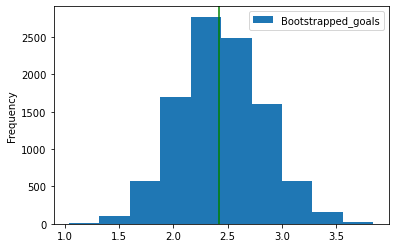

In [304]:
bootstrapped_fixtures_df.plot.hist()
plt.axvline(fixture_df['Sum Goals'].mean(), color='green')

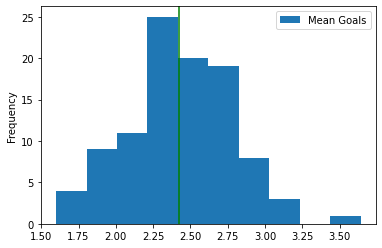

In [305]:
bootstrapped_fixtures_df_1 = pd.DataFrame({'Mean Goals' : [fixture_df['Sum Goals'].sample(25, replace=True).mean() for i in range(100)]})
bootstrapped_fixtures_df_1.plot.hist()
plt.axvline(fixture_df['Sum Goals'].mean(), color='green')

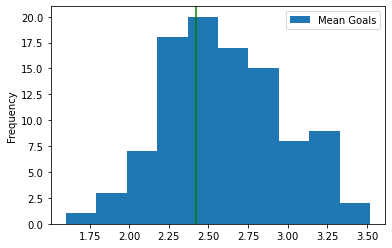

In [391]:
bootstrapped_fixtures_df_2 = pd.DataFrame({'Mean Goals' : [fixture_df['Sum Goals'].sample(25, replace=True).mean()+0.2 for i in range(100)]})
bootstrapped_fixtures_df_2.plot.hist()
plt.axvline(fixture_df['Sum Goals'].mean(), color='green')

In [412]:
def calculate_t_statistic(data1, data2, alpha = 0.05):
    #Calculate t-test
    mean1, mean2 = data1.mean(), data2.mean()
    print(f"Means: {mean1}, {mean2}")
    std1, std2 = data1.std(), data2.std()
    print(f"Stds: {std1}, {std2}")
    N1, N2 = len(data1), len(data2)
    print(f"Counts: {N1}, {N2}")
    std_err_1, std_err_2 = std1/np.sqrt(N1), std2/np.sqrt(N2)
    print(f"Std errors: {std_err_1}, {std_err_2}")
    t_stat = (mean1 - mean2)/np.sqrt(std_err_1 * std_err_1 + std_err_2 * std_err_2)
    print(f"t_stat is {t_stat}")
    
    #degrees of freedom
    deg_f = N1 + N2 - 2
    print(f"Number of deg_f are {deg_f}")
    
    #Calculating the critical value
    crit_val = t.ppf(1.0 - alpha, deg_f)
    print(f"Critical value is {crit_val}")
    
    p_val = (1.0 - t.cdf(abs(t_stat), df = deg_f)) * 2.0
    print(f"p value is {p_val:.5f}")
    
    if(p_val < alpha):
        print("Statistically significant difference, can reject null hypothesis")
    else:
        print("No statistically significant difference, cannot reject null hypothesis")
        
    if(crit_val < abs(t_stat)):
        print("Statistically significant difference, can reject null hypothesis")
    else:
        print("No statistically significant difference, cannot reject null hypothesis")
        

In [413]:
calculate_t_statistic(bootstrapped_fixtures_df_1['Mean Goals'], bootstrapped_fixtures_df_2['Mean Goals'])

Means: 2.4316000000000013, 2.603199999999999
Stds: 0.3593617237336894, 0.377495414381139
Counts: 100, 100
Std errors: 0.03593617237336894, 0.0377495414381139
t_stat is -3.2924373196038745
Number of deg_f are 198
Critical value is 1.6525857836172075
p value is 0.00118
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis


In [414]:
#Validating calculations using scipy stats t-test
scipy.stats.ttest_ind(bootstrapped_fixtures_df_1['Mean Goals'], bootstrapped_fixtures_df_2['Mean Goals'])

Ttest_indResult(statistic=-3.2924373196039425, pvalue=0.001176232992571106)

In [411]:
#Testing using shaking hands example
coffee_array = np.array([34, 52, 26, 47, 42, 37, 40])
soda_array = np.array([39, 57, 68, 74, 49, 57])
calculate_t_statistic(coffee_array, soda_array)

Means: 39.714285714285715, 57.333333333333336
Stds: 7.90504876128967, 11.527744310527055
Counts: 7, 6
Std errors: 2.9878275891730945, 4.706181907677194
t_stat is -3.160639991435542
Number of deg_f are 11
Critical value is 1.7958848187036691
p value is 0.00907
Statistically significant difference, can reject null hypothesis
Statistically significant difference, can reject null hypothesis
